In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_actions = 100  # a centipede with 100 legs

In [8]:
# utils
def onehot(idx, N): # hacky. i know...
    return np.eye(N)[idx]

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def sample(x, logits):
    # or could use gumbel trick
    p = softmax(logits)
    return np.random.choice(x, p=p)

In [107]:
class Env():
    def __init__(self, n_states, n_actions):
        """
        Args:
            n_states (int): the number of states
            n_actions (int): the number of action
        """
        self.n_actions = n_actions
        self.n_states = n_states
        self.S = np.arange(n_states)
        self.A = np.arange(n_actions)

        # each action move from state(i) to state(j) with probability close to 1.
        # BUG nope. softmax doesnt do this. will need to set to -infty
        self.P = 20*np.stack([np.random.permutation(np.eye(n_states, dtype=np.float32)) for _ in range(n_actions-1)] + [np.eye(n_states, dtype=np.float32)],axis=0)  
        # NOTE this graph might be disconnected. but is unlikely!?

        # reward is only a fn of the current state - shape = [n_states]
        # also. is sparse.
        self.R = onehot(np.random.randint(0, n_states), n_states)

    def step(self, state, action):
        """
        A tabular, probabilistic step function. 

        Args:
            state (int): An element of S. The current state
            state (int): An element of A. The action to be taken

        Returns:
            new_state (int): An element of S.
        """
        # step by selecting relevant transition matrix and applying
        logits = np.matmul(self.P[action, ...], onehot(state, self.n_states))
        # convert to a distribution and sample
        new_s = np.random.choice(self.S, p=softmax(logits))
        return new_s, self.R[new_s]
    
    def rnd_policy(self, s, *args):
        return np.random.choice(self.A)
    
    def reset(self):
        return np.random.choice(self.S)

    def new_task(self):
        self.R = onehot(np.random.randint(0, self.n_states), self.n_states)

In [375]:
class DiscreteActionWrapper(Env):
    """
    A setting for HRL.
    
    Action space structure is built into this env allowing 
    a HRL learner to abstract the action space to a more meaningful one.
    
    No explicit temporal abstraction built into this env.
    
    """
    # Q: How much harder does this make the problem?
    def __init__(self, n_input_actions,  n_states, n_actions):
        super(DiscreteActionWrapper, self).__init__(n_states, n_actions)
        
        self.n_input_actions = n_input_actions
        self.input_action_space = range(n_input_actions)
        self.proj = np.random.randint(0, 2, (n_input_actions, n_actions))
        
    def __call__(self, a):
        a = onehot(a, self.n_input_actions)
        return np.argmax(np.dot(a, self.proj))  # or coud use sample. but dont want to add extra noise
    
    def step(self, state, action):
        action = self.__call__(action)
        return super(DiscreteActionWrapper, self).step(state, action)
    
    def rnd_policy(self, s, *args):
        return np.random.choice(self.input_action_space)

In [436]:
true_n_actions = 4
n_states = 32

In [426]:
class TabularSARSA():
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = 0.999
        self.lr = 0.1

        self.qs = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = sample(np.arange(self.n_actions), self.qs[s, ...])
        # should change to epsilon greedy or entropy regularised
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!
        self.qs -= 1e-4 * self.qs  # entropy regularisation

In [456]:
def play_episode(env, player, len_episode):
    # reset
    s = env.reset()
    total_r = 0
    r = 0
    
    # play an episode
    for _ in range(len_episode):
        a = player(s, r)
        s, r = env.step(s, a)
        total_r += r
        
    return total_r/len_episode

def plot(x, label):
    x = np.array(x)
    if len(x.shape) == 2:
        n = len(x[0])
        idx = range(n)
        mean = np.mean(x, axis=0)
        stddev = np.sqrt(np.var(x,axis=0)) 

        # smooth the signals
        n_kernel = 20
        kernel = [1]*n_kernel
        mean = np.convolve(mean, kernel)[:n]/n_kernel
        stddev = np.convolve(stddev, kernel)[:n]/n_kernel

        # plot
        plt.plot(idx, mean, label=label)
        plt.fill_between(idx, mean-stddev, mean+stddev,  alpha=0.3)
        
    else:
        n = len(x)
        idx = range(n)
        n_kernel = 20
        kernel = [1]*n_kernel
        x = np.convolve(x, kernel)[:n]/n_kernel
        plt.plot(idx, x, label=label)

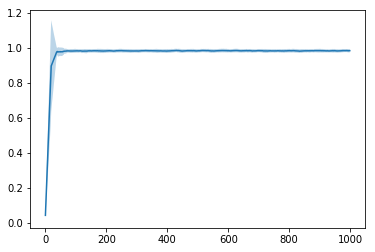

In [458]:
env = Env(n_states, true_n_actions)
sarsa = TabularSARSA(n_states, true_n_actions)
rs = np.vstack([[play_episode(env, sarsa, 100) for _ in range(1000)] for _ in range(10)])
plot(rs, 'TrueEnv')

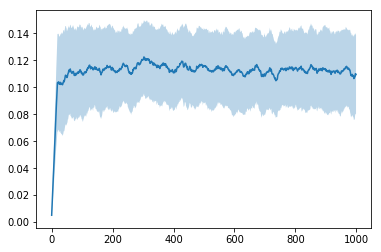

In [459]:
n_input_actions = 8
env = DiscreteActionWrapper(n_input_actions, n_states, true_n_actions)
sarsa = TabularSARSA(n_states, n_input_actions)
rs = np.vstack([[play_episode(env, sarsa, 100) for _ in range(1000)] for _ in range(10)])
plot(rs, '{}'.format(n_input_actions))

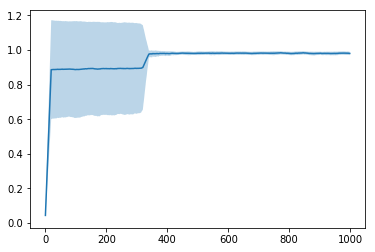

In [460]:
n_input_actions = 16
env = DiscreteActionWrapper(n_input_actions, n_states, true_n_actions)
sarsa = TabularSARSA(n_states, n_input_actions)
rs = np.vstack([[play_episode(env, sarsa, 100) for _ in range(1000)] for _ in range(10)])
plot(rs, '{}'.format(n_input_actions))

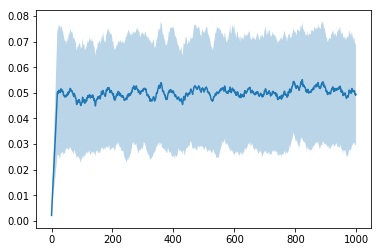

In [461]:
n_input_actions = 32
env = DiscreteActionWrapper(n_input_actions, n_states, true_n_actions)
sarsa = TabularSARSA(n_states, n_input_actions)
rs = np.vstack([[play_episode(env, sarsa, 100) for _ in range(1000)] for _ in range(10)])
plot(rs, '{}'.format(n_input_actions))

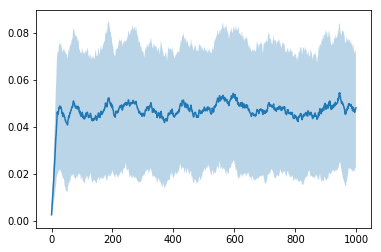

In [463]:
n_input_actions = 64
env = DiscreteActionWrapper(n_input_actions, n_states, true_n_actions)
sarsa = TabularSARSA(n_states, n_input_actions)
rs = np.vstack([[play_episode(env, sarsa, 100) for _ in range(1000)] for _ in range(10)])
plot(rs, '{}'.format(n_input_actions))